Download MODIS snow products from EURAC repository: http://saocompute.eurac.edu/rasdaman/ows#/services

In [16]:
# Import libraries
import pandas as pd
import xarray as xr
import wget
import matplotlib.pyplot as plt
from pyproj import CRS

In [17]:
def download_modis_eurac(date_start: str, date_end: str):
    """
    Download of MODIS snow products from Eurac Research: http://saocompute.eurac.edu/rasdaman/ows#/services
    Maps are reduced in size, and stored in epsg:3035.

    INPUT:
    date_start - starting date ('%Y-%m-%d')
    date_end - ending date ('%Y-%m-%d')
    """
    # Download
    print(f"Dowloading Eurac Research MODIS SCA maps from {date_start} to {date_end}...")
    url1 = 'http://saocompute.eurac.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&' \
           'REQUEST=GetCoverage&COVERAGEID=ALPS_SNOW_map_MODIS&SUBSET=DATE(%22'
    url2 = 'T12:00:00.000Z%22,%22'
    url3 = 'T12:00:00.000Z%22)&FORMAT=application/netcdf'
    url = url1 + date_start + url2 + date_end + url3
    filename = wget.download(url)

In [34]:
# Insert date start ('%Y-%m-%d')
start_date = input("Please insert the start date in the format YYYY-MM-DD: ")

# Insert end start ('%Y-%m-%d')
end_date = input("Please insert the end date in the format YYYY-MM-DD: ")

# Download Eurac Research MODIS SCA maps in the selected dates range
download_modis_eurac(start_date, end_date)

Please insert the start date in the format YYYY-MM-DD:  2003-03-03
Please insert the end date in the format YYYY-MM-DD:  2003-03-04


Dowloading Eurac Research MODIS SCA maps from 2003-03-03 to 2003-03-04...
-1 / unknown

Do you want to select a Region of Interest (if yes, type 'y'):  n


Saving the SCA map as 'EURAC_MODIS_SCA.nc'


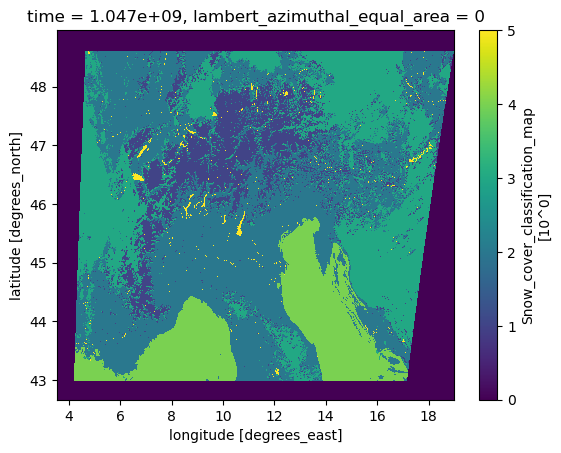

In [35]:
# Open Dataset
ds = xr.open_dataset('ALPS_SNOW_map_MODIS.nc', decode_coords="all")
var = 'Snow_cover_classification_map'

# Transform coordinates in the World Geodetic System (WGS-84; EPSG:4326)
ds = ds.rename({'DATE': 'time', 'X': 'x', 'Y': 'y'}).set_coords(['time', 'y', 'x']).transpose()
ds = ds.transpose('time', 'y', 'x').rio.reproject(CRS("WGS84"), nodata=0)

# Cut image over a selected area if requested by the user
roi = input("Do you want to select a Region of Interest (if yes, type 'y'): ")

if roi == 'y':
    lat_min = float(input("Please insert the minimum latitude (in decimal degrees): "))
    lat_max = float(input("Please insert the maximum latitude (in decimal degrees): "))
    lon_min = float(input("Please insert the minimum longitude (in decimal degrees): "))
    lon_max = float(input("Please insert the maximum longitude (in decimal degrees): "))
    ds = ds.where((ds.x <= lon_max) & (ds.x >= lon_min) & (ds.y <= lat_max) & (ds.y >= lat_min), drop=True)

# Plot the image(s) in the selected area
for t in ds.time:
    plt.figure()
    ds[var].sel(time=t).plot()

# Save the final SCA map
save_name = 'EURAC_MODIS_SCA.nc'
netcdf_encoding = {var: {'dtype': 'uint8', 'zlib': True, 'complevel': 5} for var in ds.data_vars}
print(f"Saving the SCA map as '{save_name}'")
ds.to_netcdf(save_name, engine="netcdf4", encoding=netcdf_encoding)